<a href="https://colab.research.google.com/github/Priyanshu0651/DeepIntoCNNs/blob/main/Hackathon2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!nvidia-smi

Thu Jul 15 16:34:42 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   46C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
!pip install jcopdl


  Created wheel for jcopdl: filename=jcopdl-1.1.9-py2.py3-none-any.whl size=16925 sha256=d47f5e1fde1bc68d652cfb049698878c900f1ffa97d264bc3aba0cddf8b1db41
  Stored in directory: /root/.cache/pip/wheels/bb/fd/9d/fc72bcf569000eabd487e654fdf55b587e66882b60eaa5693b
Successfully built jcopdl


In [4]:
import torch
from torchvision import datasets, transforms
from torchvision.models import mobilenet_v2
from torch import nn, optim
from torch.utils.data import DataLoader, TensorDataset
from torchvision.utils import make_grid

from tqdm.auto import tqdm
from jcopdl.callback import Callback, set_config
from jcopdl.layers import linear_block, conv_block

import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device


device(type='cuda', index=0)

##### Dataset & Dataloader

In [5]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  
# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 62 bytes


In [7]:
!kaggle datasets download -d gpiosenka/100-bird-species

100-bird-species.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
!unzip 100-bird-species.zip

In [9]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
from pylab import *

import torch
import torchvision
from torchvision import datasets, transforms

import os

In [10]:
batch_size = 128
crop_size = 224

train_transform = transforms.Compose([
    transforms.RandomRotation(10),
    transforms.RandomResizedCrop(crop_size, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

test_transform = transforms.Compose([
    transforms.Resize(230),
    transforms.CenterCrop(crop_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

train_set = datasets.ImageFolder("/content/birds/train", transform=train_transform)
trainloader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=2)

val_set = datasets.ImageFolder("/content/birds/valid", transform=test_transform)
valloader = DataLoader(val_set, batch_size=batch_size, shuffle=True)

test_set = datasets.ImageFolder("/content/birds/test", transform=test_transform)
testloader = DataLoader(test_set, shuffle=True)

In [12]:
label2cat = train_set.classes
label2cat, len(label2cat)

(['AFRICAN CROWNED CRANE',
  'AFRICAN FIREFINCH',
  'ALBATROSS',
  'ALEXANDRINE PARAKEET',
  'AMERICAN AVOCET',
  'AMERICAN BITTERN',
  'AMERICAN COOT',
  'AMERICAN GOLDFINCH',
  'AMERICAN KESTREL',
  'AMERICAN PIPIT',
  'AMERICAN REDSTART',
  'ANHINGA',
  'ANNAS HUMMINGBIRD',
  'ANTBIRD',
  'ARARIPE MANAKIN',
  'ASIAN CRESTED IBIS',
  'BALD EAGLE',
  'BALI STARLING',
  'BALTIMORE ORIOLE',
  'BANANAQUIT',
  'BANDED BROADBILL',
  'BAR-TAILED GODWIT',
  'BARN OWL',
  'BARN SWALLOW',
  'BARRED PUFFBIRD',
  'BAY-BREASTED WARBLER',
  'BEARDED BARBET',
  'BEARDED REEDLING',
  'BELTED KINGFISHER',
  'BIRD OF PARADISE',
  'BLACK & YELLOW bROADBILL',
  'BLACK FRANCOLIN',
  'BLACK SKIMMER',
  'BLACK SWAN',
  'BLACK TAIL CRAKE',
  'BLACK THROATED BUSHTIT',
  'BLACK THROATED WARBLER',
  'BLACK VULTURE',
  'BLACK-CAPPED CHICKADEE',
  'BLACK-NECKED GREBE',
  'BLACK-THROATED SPARROW',
  'BLACKBURNIAM WARBLER',
  'BLUE GROUSE',
  'BLUE HERON',
  'BOBOLINK',
  'BORNEAN BRISTLEHEAD',
  'BORNEAN LEAFBIRD

In [13]:
feature, target = next(iter(trainloader))
feature.shape

torch.Size([128, 3, 224, 224])

In [14]:
class CustomMobileNetv2(nn.Module):
  def __init__(self, output_size):
    super().__init__()
    self.mnet = mobilenet_v2(pretrained=True)
    self.freeze()

    self.mnet.classifier = nn.Sequential(
        nn.Linear(1280, output_size),
        nn.LogSoftmax(1)
    )

  def forward(self, x):
    return self.mnet(x)
  
  def freeze(self):
    for param in self.mnet.parameters():
      param.requires_grad = False

  def unfreeze(self):
    for param in self.mnet.parameters():
      param.requires_grad = True

In [15]:
config = set_config({
    'batch_size': batch_size,
    'crop_size': crop_size,
    'output_size': len(train_set.classes)
})

Adaptation

In [16]:
model = CustomMobileNetv2(config.output_size).to(device)
criterion = nn.NLLLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001)
callback = Callback(model, config, early_stop_patience=2, outdir='model')

Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth


In [17]:
def loop_fn(mode, dataset, dataloader, model, criterion, optimizer, device):
  if mode == 'train':
    model.train()
  elif mode == 'val':
    model.eval()
  
  cost = correct = 0
  for feature, target in tqdm(dataloader, desc=mode.title()):
    feature, target = feature.to(device), target.to(device)
    output = model(feature)
    loss = criterion(output, target)

    if mode == 'train':
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()
    
    cost += loss.item() * feature.shape[0]
    correct += (output.argmax(1) == target).sum().item()
  cost = cost/len(dataset)
  acc = correct/len(dataset)
  return cost, acc



Epoch     1
Train_cost  = 2.0245 | Test_cost  = 0.5727 | Train_score = 0.6627 | Test_score = 0.9142 |




Epoch     2
Train_cost  = 0.6348 | Test_cost  = 0.3506 | Train_score = 0.8775 | Test_score = 0.9302 |




Epoch     3
Train_cost  = 0.4523 | Test_cost  = 0.2762 | Train_score = 0.9053 | Test_score = 0.9396 |




Epoch     4
Train_cost  = 0.3640 | Test_cost  = 0.2328 | Train_score = 0.9188 | Test_score = 0.9447 |




Epoch     5
Train_cost  = 0.3041 | Test_cost  = 0.2120 | Train_score = 0.9294 | Test_score = 0.9513 |




Epoch     6
Train_cost  = 0.2698 | Test_cost  = 0.1979 | Train_score = 0.9368 | Test_score = 0.9527 |




Epoch     7
Train_cost  = 0.2408 | Test_cost  = 0.1919 | Train_score = 0.9421 | Test_score = 0.9476 |
==> EarlyStop patience =  1 | Best test_score: 0.9527




Epoch     8
Train_cost  = 0.2176 | Test_cost  = 0.1938 | Train_score = 0.9471 | Test_score = 0.9498 |
==> EarlyStop patience =  2 | Best test_score: 0.9527
==> Execute Early Stopping at epoch: 8 | Best test_score: 0.9527
==> Best model is saved at model


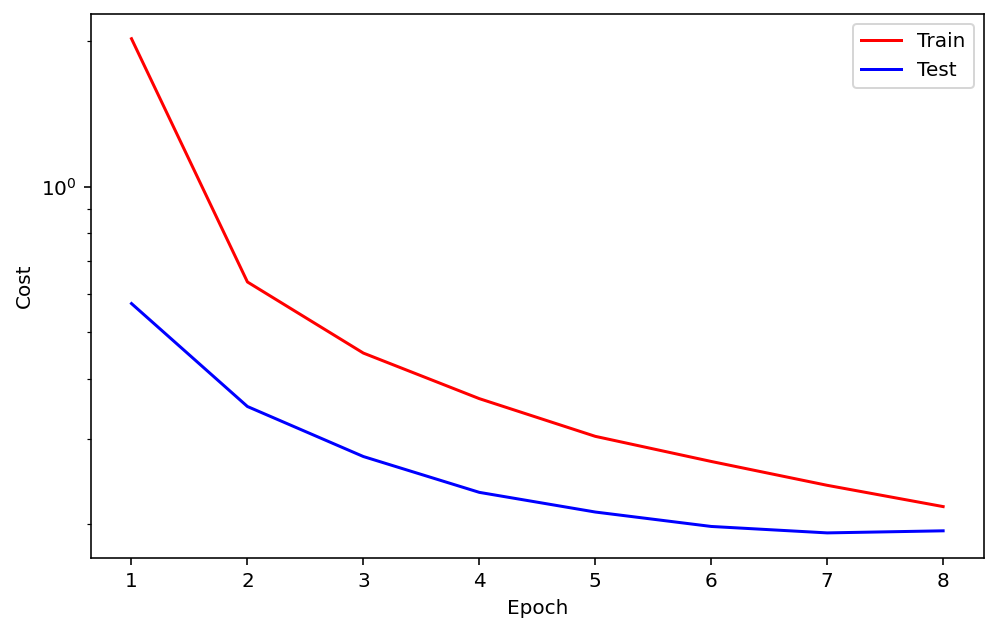

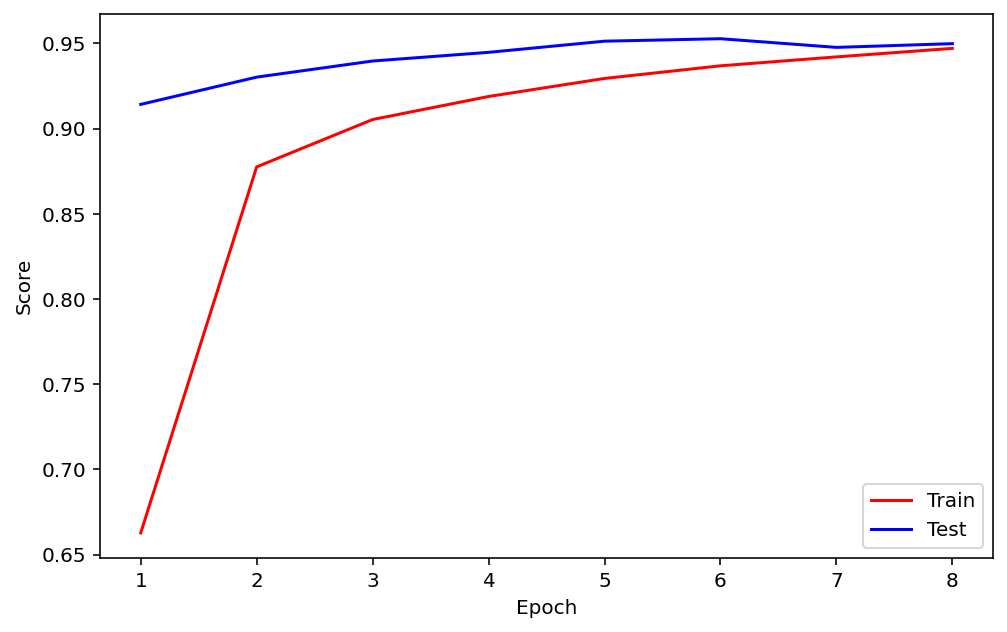

In [18]:
while True:
  train_cost, train_score = loop_fn('train', train_set, trainloader, model, criterion, optimizer, device)
  with torch.no_grad():
    test_cost, test_score = loop_fn('val', val_set, valloader, model, criterion, optimizer, device)

  # Logging
  callback.log(train_cost, test_cost, train_score, test_score)

  # Checkpoint
  callback.save_checkpoint()

  # Runtime Plotting
  callback.cost_runtime_plotting()
  callback.score_runtime_plotting()

  # Early Stopping
  if callback.early_stopping(model, monitor='test_score'):
    callback.plot_cost()
    callback.plot_score()
    break

Fine-Tuning

In [19]:
model.unfreeze()
optimizer = optim.AdamW(model.parameters(), lr=1e-5)

callback.reset_early_stop()
callback.early_stop_patience = 3



Epoch     9
Train_cost  = 0.1727 | Test_cost  = 0.1257 | Train_score = 0.9627 | Test_score = 0.9716 |




Epoch    10
Train_cost  = 0.1378 | Test_cost  = 0.1114 | Train_score = 0.9699 | Test_score = 0.9731 |




Epoch    11
Train_cost  = 0.1192 | Test_cost  = 0.1074 | Train_score = 0.9754 | Test_score = 0.9724 |
==> EarlyStop patience =  1 | Best test_score: 0.9731




Epoch    12
Train_cost  = 0.1076 | Test_cost  = 0.1008 | Train_score = 0.9781 | Test_score = 0.9767 |




Epoch    13
Train_cost  = 0.0966 | Test_cost  = 0.0938 | Train_score = 0.9800 | Test_score = 0.9745 |
==> EarlyStop patience =  1 | Best test_score: 0.9767




Epoch    14
Train_cost  = 0.0883 | Test_cost  = 0.0921 | Train_score = 0.9830 | Test_score = 0.9789 |




Epoch    15
Train_cost  = 0.0812 | Test_cost  = 0.0936 | Train_score = 0.9852 | Test_score = 0.9782 |
==> EarlyStop patience =  1 | Best test_score: 0.9789




Epoch    16
Train_cost  = 0.0767 | Test_cost  = 0.0881 | Train_score = 0.9857 | Test_score = 0.9782 |
==> EarlyStop patience =  2 | Best test_score: 0.9789




Epoch    17
Train_cost  = 0.0699 | Test_cost  = 0.0869 | Train_score = 0.9874 | Test_score = 0.9789 |
==> EarlyStop patience =  3 | Best test_score: 0.9789
==> Execute Early Stopping at epoch: 17 | Best test_score: 0.9789
==> Best model is saved at model


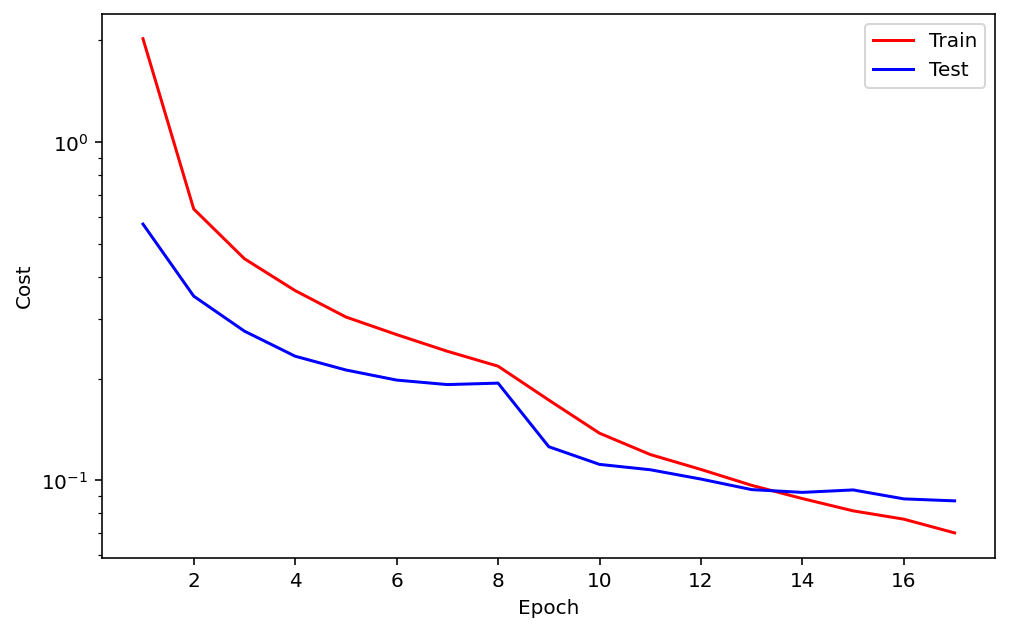

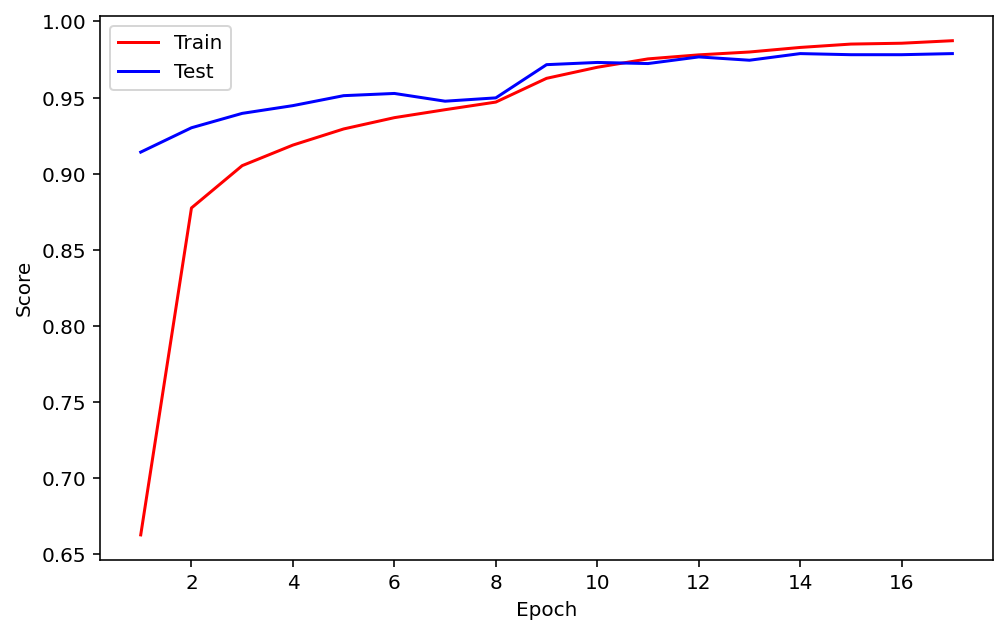

In [20]:
while True:
  train_cost, train_score = loop_fn('train', train_set, trainloader, model, criterion, optimizer, device)
  with torch.no_grad():
    test_cost, test_score = loop_fn('val', val_set, valloader, model, criterion, optimizer, device)

  # Logging
  callback.log(train_cost, test_cost, train_score, test_score)

  # Checkpoint
  callback.save_checkpoint()

  # Runtime Plotting
  callback.cost_runtime_plotting()
  callback.score_runtime_plotting()

  # Early Stopping
  if callback.early_stopping(model, monitor='test_score'):
    callback.plot_cost()
    callback.plot_score()
    break